# Part 3: GW events 

This tutorial will show some basic processing steps employed to analyse strain data in the attemp to find GW signals

#### Acknowledgments: 
1) This tutorial was inspired by the Gravitational Wave Open Data Workshop 2018 organized by the LIGO Scientific Collaboration which was held on The California Institute of Technology (Caltech).

2) We will be using the PyCBC library [DOI: 10.5281/zenodo.1472015], which is a open library used to study GW strain data, find astrophysical sources generated by CBC, and study their parameters. Then, we will be using here some of the same tools that were used by the LIGO/Virgo scientific collaboration to find the GW events GW150914, GW151226, GW170104, GW170608, GW170814 and GW170817. 

3) Some reference papers are: *(i)* "The PyCBC search for gravitational waves from compact binary coalescence" arXiv:1508.02357; *(ii)* "PyCBC Inference: A Python-based parameter estimation toolkit for compact binary coalescence signals" arXiv:1807.10312.

4) This research has made use of data, software and/or web tools obtained from the Gravitational Wave Open Science Center (https://www.gw-openscience.org), a service of LIGO Laboratory, the LIGO Scientific Collaboration and the Virgo Collaboration. LIGO is funded by the U.S. National Science Foundation. Virgo is funded by the French Centre National de Recherche Scientifique (CNRS), the Italian Istituto Nazionale della Fisica Nucleare (INFN) and the Dutch Nikhef, with contributions by Polish and Hungarian institutes.

#### Aditional information:
1) For more information, please visit http://www.gravitationalwaves.mx

2) If you are interested in collaborations with us, please contact Dr. Claudia Moreno claudia.moreno@academico.udg.mx

3) We would like to thank the support of the National Council of Science and Technology of Mexico (CONACyT) through "Red Temática de Agujeros Negros y Ondas Gravitatorias" (http://www.redtematicaanyog.mx).

## 3.1 Accessing and plotting raw LIGO data around the GW150914 event

We will retrieve strain data from both Handford and Livingston detector around the GW150914 event and we will plot it

In [43]:
# Get strain data around GW150914
from pycbc.catalog import Merger
import pylab

event = Merger('GW150914')

data = {}
for ifo in ['H1','L1']:
    data[ifo] = event.strain(ifo)

4096.0
4096.0


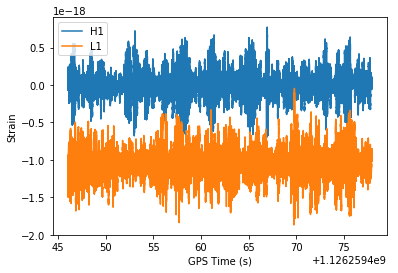

In [44]:
# Plot retrieved data
for ifo in data:
    pylab.plot(data[ifo].sample_times, data[ifo], label=ifo)
    fs = 1/data[ifo].delta_t
    print(fs)

pylab.ylabel('Strain')
pylab.xlabel('GPS Time (s)')
pylab.legend()
pylab.show()



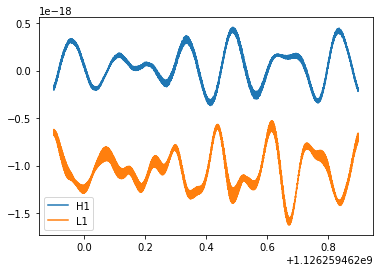

In [45]:
# Zooming into 1 second nearby GW150914 merger (recall that the merger is in the middle)
for ifo in data:
    # The time slice method can give just a portion of the time series using GPS start and stop times
    zoom = data[ifo].time_slice(event.time - 0.5,event.time + 0.5)
    pylab.plot(zoom.sample_times,zoom,label=ifo)

pylab.legend()
pylab.show()

# PILAS: note that all we can see is a low frequency behavior of the noise, since it is much louder
# than the higher frequency noise (and signal).

## 3.2 Data processing: highpass filtering

We will apply now a highpass filter to the data to suppress the low frequency noise of the instrument. We can see that this brings the dynamic range of the data largely into the same range.

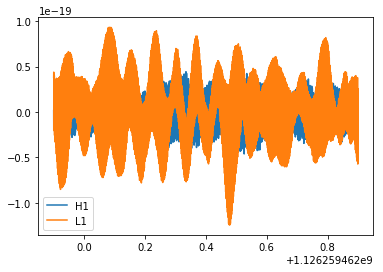

In [46]:
for ifo in data:
    # Apply a highpass filter to the data. This suppresses the low
    # frequency content of the data. We choose here a finite-impulse-response (FIR).
    high_data = data[ifo].highpass_fir(15, 512) # Highpass point is 15 Hz
    
    # The time slice method can give just a portion of the time
    # series using GPS start and stop times
    zoom = high_data.time_slice(event.time - 0.5, event.time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.legend()
pylab.show()

## 3.3 Power spectral density (PSD) of the filtered data

Understanding how the noise power varies over frequency is important for LIGO data analysis. In this 
section we use a version of [Welch's method](https://en.wikipedia.org/wiki/Welch%27s_method)
to estimate the power spectral density of the data.

Note that there is a significant amount of noise at low frequencies (orders of magnitude). Note also that there is a large amount of power at a few specific frequencies. The causes for these include 60 Hz power line noise, violin modes of the hanging mirrors, and various other instrumental resonances. The downturn in power before 2 KHz is due to a low pass filter that was applied prior to resampling the data to 4096 Hz.

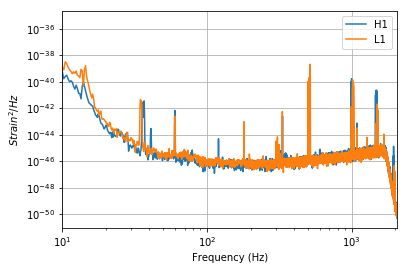

In [47]:
for ifo in data:
    # This estimates the PSD by sub-dividing the data into overlapping
    # 4s long segments. (See Welch's method)
    psd = data[ifo].psd(4)
    
    # Note that the psd is a FrequencySeries!
    pylab.loglog(psd.sample_frequencies, psd, label=ifo)
    
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.xlim(10, 2048)
pylab.legend()
pylab.show()

## 3.4 Data processing: whitening and bandpass filtering

Despite the highpass filtering, there is clearly still some dominant frequencies. To equalize this, we would need to apply more processing steps. Below we will whiten the data, and then bandpass the result to focus on a specific frequency range.

### Whithening

Whitening takes the data and attempts to make the power spectral density flat, so that all frequencies contribute equally.

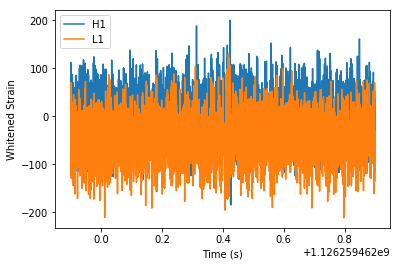

In [48]:
# Whiten the data
whitened = {}

for ifo in data:
    # This produces a whitened set.
    # This works by estimating the power spectral density from the
    # data and then flattening the frequency response.
    # (1) The first option sets the duration in seconds of each
    #     sample of the data used as part of the PSD estimate.
    # (2) The second option sets the duration of the filter to apply
    whitened[ifo] = data[ifo].whiten(4,4)

    zoom = whitened[ifo].time_slice(event.time-0.5,event.time+0.5)
    pylab.plot(zoom.sample_times,zoom,label=ifo)

pylab.ylabel('Whitened Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

### Bandpass filtering

This will remove frequency ranges which won't contribute to this kind of signal and make it possible to see the signal in question.

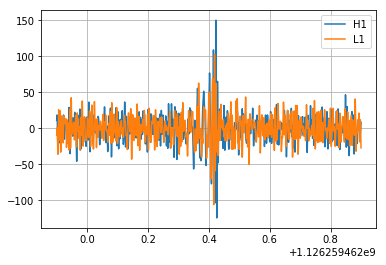

In [49]:
# Bandpass filtering between 30 - 250 Hz.
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30,512).lowpass_fir(250,512)
    
    zoom = bpsd.time_slice(event.time-0.5,event.time+0.5)
    pylab.plot(zoom.sample_times,zoom,label=ifo)

pylab.grid()
pylab.legend()
pylab.show()

#### Focus the plot around GW150914

In the above plot we can see that there is some excess signal that sticks above the noise. Let's zoom around this time now, and align the two time series.

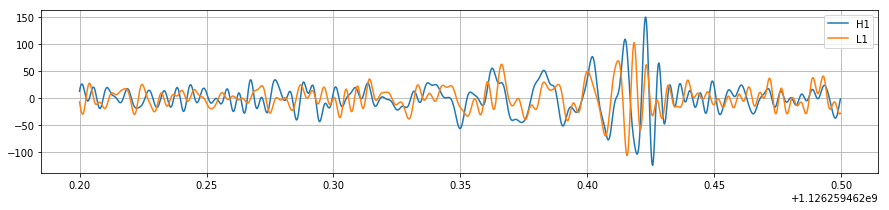

In [50]:
# Zooming into 0.2 and 0.1 seconda nearby GW150914 merger
pylab.figure(figsize=[15, 3])
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    # We'll choose a tighter zoom here.
    zoom = bpsd.time_slice(event.time-0.2,event.time+.1)
    pylab.plot(zoom.sample_times,zoom,label=ifo)
pylab.grid()
pylab.legend()
pylab.show()

#### Signal Aligment

In the above plot we can see that there is some excess signal that sticks above the noise. Let's zoom around this time now, and align the two time series.

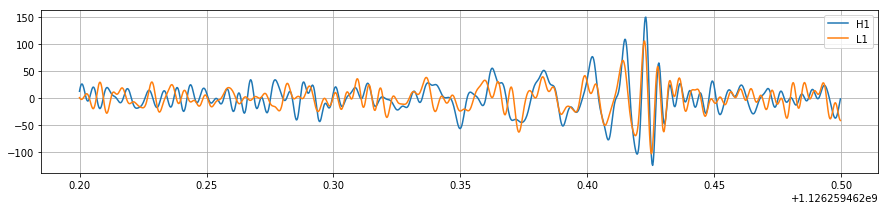

In [51]:

pylab.figure(figsize=[15, 3])
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(30, 512).lowpass_fir(250, 512)
    
    # Now we'll specially align the L1 data. Where does this come from?
    # (1) We already knew that the signal was ~ 7 ms separated between detectors.
    # (2) The two LIGO interferometers are roughly aligned so that the output of
    #     one is a sign change of the other for *many* sky locations. This is an
    #     approximation and doesn't hold for all possible source sky locations.
    # A later tutorial will show how to estimate this alignment more precisely.
    if ifo == 'L1':
        bpsd.roll(int(bpsd.sample_rate * .007))
        bpsd *= -1
    
    # We'll choose a tighter zoom here.
    zoom = bpsd.time_slice(event.time-0.2,event.time+.1)
    pylab.plot(zoom.sample_times, zoom, label=ifo)

pylab.grid()
pylab.legend()
pylab.show()

We can now see that there is a coherent signal that matches in phase for a few cycles, which ends at about 0.44 on the plot above. 

## 3.5 Visualizing excesses in the data with a Q-transform plot

A common way to visualize gravitational-wave data is with a time-frequency representation known as the [constant-Q transform](https://en.wikipedia.org/wiki/Constant-Q_transform). It is similar to a standard spectrogram made with short-time Fourier transforms with the advantage that frequency bins are more sparsely spaced at high freqeuncys.

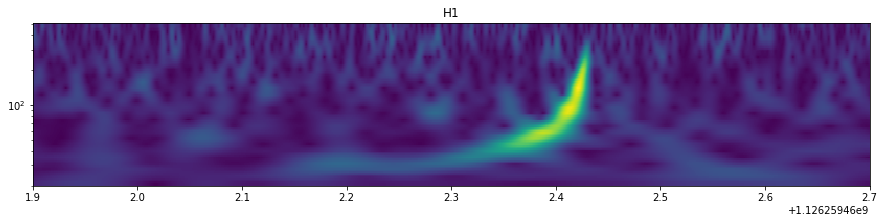

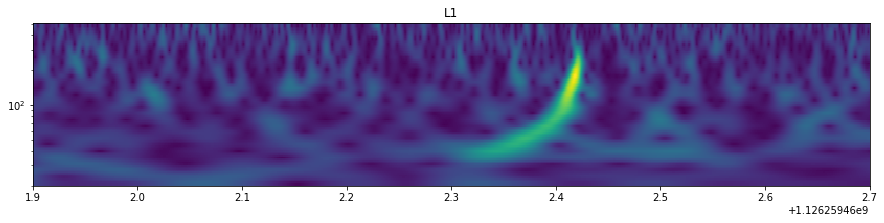

In [52]:
for ifo in whitened:
    # We'll choose a tighter zoom here.
    zoom = whitened[ifo].time_slice(event.time-5,event.time+5)
                    
    # The qtransform method returns a vector of the sample times, frequencies, and a 2-d vector of the 
    # power in each time-frequency bin. The free parameter is the choice of the Q-value. Larger Q-values
    # are generally more appropriate for viewing long duration features of the data and vice versa. 
                    
    # The options here:
    # (1) The time spacing for the output image (i.e. 1 ms in this case)
    # (2) The number of frequency bins in the output, logarithmically spaced
    # (3) The qrange to maximize over. We'll pick a constat at 15 here
    # (4) The frequency range to output
    times, freqs, power = zoom.qtransform(.001, logfsteps=100,
                                                qrange=(8, 8),
                                                frange=(20, 512),
                                         )
    pylab.figure(figsize=[15, 3])
    pylab.pcolormesh(times, freqs, power**0.5)
    pylab.xlim(event.time-0.5,event.time+0.3)
    pylab.title(ifo)
    pylab.yscale('log')
    pylab.show()

The GW150914 signal is relatively clear in the qtransform output, which is why the Q-transform can be a powerful diagnostic. However, note that quieter signals, especially those with lower masses than GW150914 had, will be harder to spot visually. In practice, we use a technique called [matched filtering](https://en.wikipedia.org/wiki/Matched_filter) to find signals in our data.

## 3.6 Activity

Modify this script to read, plot and analize the strain signal of an event also observed with V1. 
